In [348]:
import numpy as np
import qiskit as q
from qiskit import QuantumCircuit, transpile, assemble, Aer, IBMQ, QuantumRegister, AncillaRegister
from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info import Statevector
from qiskit.visualization import array_to_latex
import matplotlib as mpl
import matplotlib.pyplot as plt

In [349]:
#parameters

M = 8 # lattices

w1 = 0.5 
w2 = 0.5 
e1 = 1   ##right
e2 = -1  ##left
cs = 1   ##speed of sound
u = 0.2  ##advection 


x = w1*(1+e1*u/cs**2)
y = w2*(1+e2*u/cs**2)
print(x,y)
lambda1 = np.round(np.log(complex(x, np.sqrt(1-x**2))), 10)
lambda2 = np.round(np.log(complex(y, np.sqrt(1-y**2))), 10)

0.6 0.4


In [350]:
def oneStep(lambda1,lambda2):
    
    #initializing
    n = int(np.log2(2*M))
    q = QuantumRegister(n,'q')
    a = AncillaRegister(1,'a')

    qc = QuantumCircuit(q)
    qc.add_register(a)
     
    qc.barrier()
    
    
    #collisions
    def createC(lambda1, lambda2, isC1 = True):
    
        if not isC1:
            lambda1=np.conj(lambda1)
            lambda2=np.conj(lambda2)

        lambda1=lambda1.imag
        lambda2=lambda2.imag

        qc=QuantumCircuit(2)

        #phase1 -> x -> phase1 -> x -----ctrl=0
        qc.cp(lambda1, 0 ,1 , ctrl_state = 0)
        qc.cx(0, 1, ctrl_state = 0)
        qc.cp(lambda1, 0, 1, ctrl_state = 0)
        qc.cx(0, 1, ctrl_state = 0)

        #phase2 -> x -> phase2 -> x -----ctrl=1 is default
        qc.cp(lambda2, 0, 1, ctrl_state = 1)
        qc.cx(0, 1)
        qc.cp(lambda2, 0, 1, ctrl_state = 1)
        qc.cx(0, 1)

        return qc
    
    C1 = createC(lambda1, lambda2, True)
    c1gate = C1.to_gate(label = 'c1')
    C2 = createC(lambda1, lambda2, False)
    c2gate = C2.to_gate(label = 'c2')
    
    #####adding steps to circuit
    qc.h(a)
    
    ##c1 and c2 act on every qubit controlled on ancilla
    for i in range(n):
        ##qc.append(c1gate.control(1, ctrl_state = 0),[a,n-1,i])
        qc.append(c1gate,[a,i])
    for i in range(n):
        ##qc.append(c2gate.control(1, ctrl_state = 1),[a,n-1,i])
        qc.append(c2gate,[a,i])
    qc.h(a)
    qc.draw()
    
    
    
    #propagation
    def rshift(n):
        circ = QuantumCircuit(n)
        for i in range(n):
            if i == n-1:
                circ.x(i)
            else:
                circ.mcx(list(range(i+1,n)), i)
        return circ

    def lshift(n):
        circ = QuantumCircuit(n)
        for i in reversed(range(n)):
            if i == n-1:
                circ.x(i)
            else:
                circ.mcx(list(range(i+1,n)), i)
        return circ

    R = rshift(n).to_gate(label = "R").control(1, ctrl_state = 0)
    L = lshift(n).to_gate(label = "L").control(1, ctrl_state = 1)
    
    cbits = [a]
    cbits.extend([i for i in range(n-1,-1,-1)])  #### could also be [i for i in range(n-1,-1,-1)]

    qc.append(R,cbits)
    qc.append(L,cbits)

    
    ######################### macros
#     qc.swap(a,n-1)
#     qc.h(a)
    #### -> not sure if there is an extra step
    
    return qc

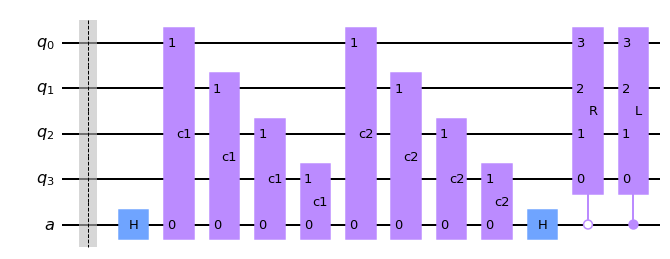

In [351]:
qc = oneStep(lambda1,lambda2)
qc.draw()

In [352]:
def splitState(ar):
    new = [0 for i in range(2*M)]
    for i in range(M):
        new[i] = ar[i]*x
        new[i+M] = ar[i]*y
    return new

In [353]:
##initialization
classicalState = [0.1 for i in range(M)]
classicalState[3] = 0.2
tmp = splitState(classicalState)

normState = tmp/np.linalg.norm(tmp) # to normalize
sv = Statevector(normState)
sv = sv.tensor([1,0])
normSV = sv
array_to_latex(sv, max_size = 256)
# print(len(classicalState),len(tmp2),len(np.array(sv)))

<IPython.core.display.Latex object>

In [354]:
sv = sv.evolve(qc)
array_to_latex(np.array(sv)[::1],max_size=256)

<IPython.core.display.Latex object>

/Users/sriharshakocherla/Documents/projects/pythonProjects/quantum/quant/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/sriharshakocherla/Documents/projects/pythonProjects/quantum/quant/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


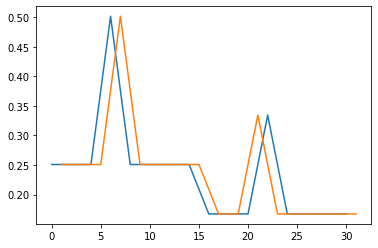

In [355]:
plt.plot(list(range(0,4*M,2)), np.array(normSV)[::2])
plt.plot(list(range(1,4*M,2)), np.array(sv)[1::2])

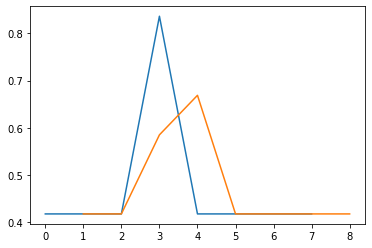

In [356]:
##do macros classicaly when circuit ends with RL gates
tmpx = np.array(normSV)[::2]
tmpy = np.array(sv)[1::2]
def read(ar):
    new = []
    for i in range(8):
        new.append(ar[i]+ar[i+8])
    return new
plt.plot(list(range(0,M,1)), read(tmpx)[::1])
plt.plot(list(range(1,M+1,1)), read(tmpy)[::1])